### *Analysis of Toronto Bike Share Ridership*

Toronto is one of Canada's largest cities, with a diverse population that is continuing to see a lot of growth. With a growing big city there are a lot of challenges, one of these challenges is transportation. One of the steps Toronto has taken to tackle this challenge is the introduction of bike sharing. In this analysis we are looking at data collected from this bike sharing project from July 2016 to Dec 2017 to see how the bike sharing project has performed. 

## Table of Contents

<ul style="font-size:16px;">
    <li><a href="#Data-Preperation">Data Preperation</a>
        <ul>
            <li><a href="#read-data">Read Data</a></li>
            <li><a href="#cleaning-data">Cleaning the Data</a></li>
            <li><a href="#creating-columns">Creating New Attributes</a></li>
            <li><a href="#save-data">Saving the Data</a></li>
        </ul>
    </li>
    <li><a href="#Analysis">Analysis</a>
        <ul>
            <li><a href="#usage-overview">Member vs. Caual usage Overview</a></li>
            <li><a href="#time-usage">Usage over different timeframes</a>
                <ul>
                    <li><a href="#count-usage">Who uses the service more?</a></li>
                    <li><a href="#duration-used">Who uses the service for a longer duration?</a></li>
                </ul>
            </li>
            <li><a href="#station-traffic">Station Traffic</a>
                <ul>
                    <li><a href="#top-20">Top 20 Station by usage</a></li>
                    <li><a href="#common-routes">5 most commonly travelled routes</a></li>
                </ul>
            </li>
        </ul>
    </li>
    <li><a href="#Conclusion">Conclusion</a></li>
</ul><br>

__Notes__

- The data we are using in this analysis comes from the [Toronto Open Data Portal](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/)
- We are not using the 2014 and 2015 data provided, because that is in a different format and there is quite a bit of data missing between then and the data we are using

## Data Preperation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<a id="read-data"></a>

### Read Data

##### Read files into DataFrame

In [2]:
Q3_2016 = pd.read_csv('data/2016Q3.csv')
Q4_2016 = pd.read_csv('data/2016Q4.csv')
Q1_2017 = pd.read_csv('data/2017Q1.csv')
Q2_2017 = pd.read_csv('data/2017Q2.csv')
Q3_2017 = pd.read_csv('data/2017Q3.csv')
Q4_2017 = pd.read_csv('data/2017Q4.csv')

##### Convert datetime according to the format in the file

In [3]:
Q3_2016["trip_start_time"] = pd.to_datetime(Q3_2016["trip_start_time"], errors="coerce", format="%m-%d-%y %H:%M")
Q3_2016["trip_stop_time"] = pd.to_datetime(Q3_2016["trip_stop_time"], errors="coerce", format="%m-%d-%y %H:%M") 

In [4]:
Q4_2016["trip_start_time"] = pd.to_datetime(Q4_2016["trip_start_time"], errors="coerce", dayfirst=True)
Q4_2016["trip_stop_time"] = pd.to_datetime(Q4_2016["trip_stop_time"], errors="coerce", dayfirst=True) 

In [5]:
Q1_2017["trip_start_time"] = pd.to_datetime(Q1_2017["trip_start_time"], errors="coerce", format="%d/%m/%Y %H:%M")
Q1_2017["trip_stop_time"] = pd.to_datetime(Q1_2017["trip_stop_time"], errors="coerce", format="%d/%m/%Y %H:%M") 

In [6]:
Q2_2017["trip_start_time"] = pd.to_datetime(Q2_2017["trip_start_time"], errors="coerce", format="%d/%m/%Y %H:%M")
Q2_2017["trip_stop_time"] = pd.to_datetime(Q2_2017["trip_stop_time"], errors="coerce", format="%d/%m/%Y %H:%M") 

In [7]:
Q3_2017["trip_start_time"] = pd.to_datetime(Q3_2017["trip_start_time"], errors="coerce", format="%m/%d/%Y %H:%M")
Q3_2017["trip_stop_time"] = pd.to_datetime(Q3_2017["trip_stop_time"], errors="coerce", format="%m/%d/%Y %H:%M")

In [8]:
Q4_2017["trip_start_time"] = pd.to_datetime(Q4_2017["trip_start_time"], errors="coerce", format="%m/%d/%y %H:%M:%S") 
Q4_2017["trip_stop_time"] = pd.to_datetime(Q4_2017["trip_stop_time"], errors="coerce", format="%m/%d/%y %H:%M:%S") 

##### Delete `from_station_id` and `to_station_id` from Q1 and Q2 in 2017 because it isn't there for the other data files


In [9]:
Q1_2017 = Q1_2017.drop(columns=['from_station_id','to_station_id'])

In [10]:
Q2_2017 = Q2_2017.drop(columns=['from_station_id','to_station_id'])

##### Combine the dataframes in one dataframe

In [11]:
df = pd.concat([Q3_2016, Q4_2016, Q1_2017, Q2_2017, Q3_2017, Q4_2017])

<a id="cleaning-data"></a>

### Cleaning the Data

##### Drop the `trip_id` because it adds no value to our analysis

In [12]:
df = df.drop(columns=['trip_id'])

##### Drop duplicates

In [13]:
# We had 3878 duplicate rows 
df = df.drop_duplicates(keep='first')

##### Drop records before 2016

In [14]:
# A random record from the year 2000 was messing things up a bit
df = df[(df['trip_start_time'].dt.year >= 2016)]

##### Drop records outside the 99.9% quantile for the trip_duration

In [15]:
# This is to remove any outliers. There was a record in the dataset with a trip duration of ~72 days.
df = df[df["trip_duration_seconds"] < df["trip_duration_seconds"].quantile(0.999)]

<a id="creating-columns"></a>

### Creating new attributes

##### Function for creating a season attribute

In [16]:
seasons = { 1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Fall", 10: "Fall", 11: "Fall", 12: "Winter" }
def getSeason(month):
    return seasons[month]

##### Function for creating a month attribute

In [17]:
month_names = { 1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec" }
def getMonth(month):
    return month_names[month]

##### Creating Day of week, weekend_or_weekday, hour, and month attributes

In [18]:
# This operation can take a little bit of time because of the apply functions.
# It should still be really fast, because we are using a dictionary to get the values. O(1) complexity 

df['day_of_week'] = df['trip_start_time'].dt.weekday_name
df['weekday_or_weekend'] = np.where(df['day_of_week'].isin(['Sunday','Saturday']),'weekend','weekday')
df['hour'] = df['trip_start_time'].dt.hour
df['month'] = df.apply(lambda x: getMonth(x['trip_start_time'].month), axis=1)
df['season'] = df.apply(lambda x: getSeason(x['trip_start_time'].month), axis=1)

<a id="save-data"></a>

### Save the Data

In [19]:
# Sort the date by start time before saving
df = df.sort_values(by="trip_start_time")

In [20]:
df.to_csv("formattedData.csv", index=False)

## Analysis

In [21]:
df = pd.read_csv('formattedData.csv')

In [22]:
# Convert from object to datetime format
df["trip_start_time"] = pd.to_datetime(df["trip_start_time"], errors="coerce", infer_datetime_format=True) # Convert from string to datetime
df["trip_stop_time"] = pd.to_datetime(df["trip_stop_time"], errors="coerce", infer_datetime_format=True) # Convert from string to datetime

##### DataFrame Sample

In [23]:
df.sample(5)

,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,day_of_week,weekday_or_weekend,hour,month,season
86345,2016-07-26 16:47:00,2016-07-26 16:57:00,577,Richmond St E / Jarvis St Green P,Simcoe St / Wellington St W,Member,Tuesday,weekday,16,Jul,Summer
1762330,2017-10-08 21:39:33,2017-10-08 21:54:08,875,Nelson St / Duncan St,Mill St / Tannery Rd,Member,Sunday,weekend,21,Oct,Fall
454577,2016-10-26 13:42:00,2016-10-26 13:52:00,579,Spadina Ave / Sussex Ave,College Park South,Member,Wednesday,weekday,13,Oct,Fall
1441502,2017-08-26 13:38:00,2017-08-26 13:52:00,819,King St W / Bay St (East Side),King St W / Tecumseth St,Casual,Saturday,weekend,13,Aug,Summer
550418,2016-12-01 23:23:00,2016-12-01 23:42:00,1131,Edward St / Yonge St,East Liberty St / Pirandello St,Member,Thursday,weekday,23,Dec,Winter


<a id="usage-overview"></a>

#### Member vs. Casual Usage Overview

##### New dataframe with memeber and casual user count

In [24]:
usage = pd.DataFrame({"Member":df[(df['user_type'] == 'Member')]["trip_start_time"].dt.date.value_counts(), "Casual":df[(df['user_type'] == 'Casual')]["trip_start_time"].dt.date.value_counts(), "Total": df["trip_start_time"].dt.date.value_counts()})

In [25]:
usage.index = pd.to_datetime(usage.index)

##### Plotting the data

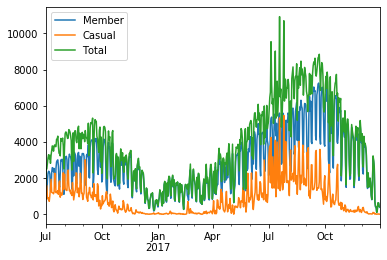

In [26]:
# All the data points - difficult to understand
usage.plot.line()

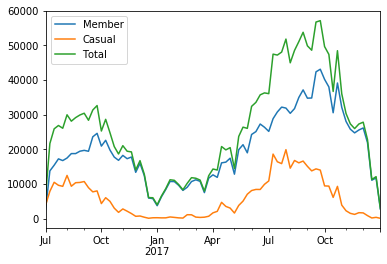

In [27]:
# Resampled data to weekly sum
usage.resample("W").sum().plot.line()

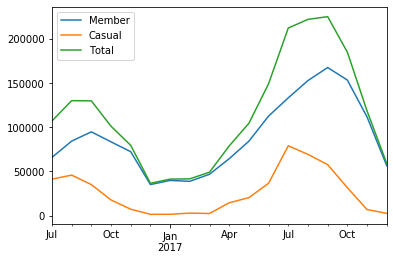

In [28]:
# Resampled data to monthly sum for a smoother curve
usage.resample("M").sum().plot.line()

##### Usage DataFrame Sample

In [29]:
usage.sample(5)

,Member,Casual,Total
2017-05-16,3508,367,3875
2017-12-05,3735,154,3889
2017-02-19,968,709,1677
2017-12-08,3266,88,3354
2016-09-16,4097,1223,5320


<a id="time-usage"></a>

### Usage over different timeframes

##### Make the `trip_start_time` the index

In [30]:
new_df = df.set_index("trip_start_time")

<a id="count-usage"></a>

#### Usage Graphs

__** Note:__ For Season and Month usage graphs the data is a skewed because we our data includes 2016 July-Dec and 2017 July-Dec. But it only contains 2017 Jan-Jun. That's why the Season and months graph look a bit lopsided. This isn't an issue in the duration usage graphs further below because that's based on mean duration used. <br>
I've chosen to still include these two graphs because they still bring the point accross about the usage breakdown between members and casual users.

##### Season Usage **

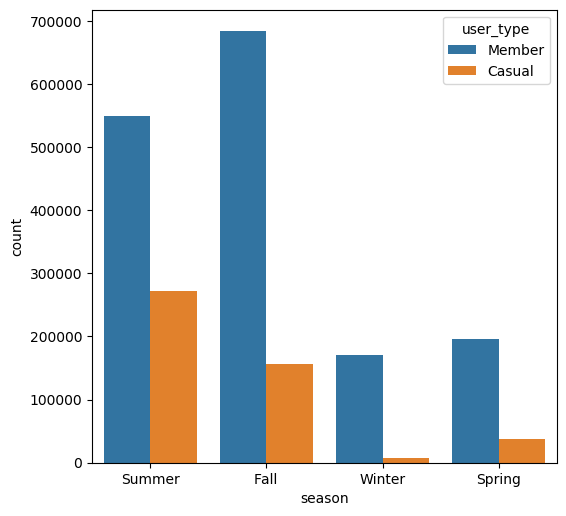

In [31]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.countplot(data=new_df, x="season", hue="user_type")
plt.show()

##### Monthly Usage **

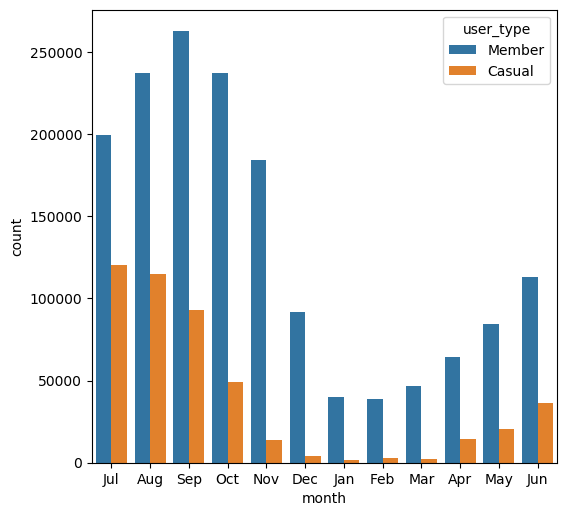

In [32]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.countplot(data=new_df, x="month", hue="user_type")
plt.show()

##### Weekend vs. Weekday Usage

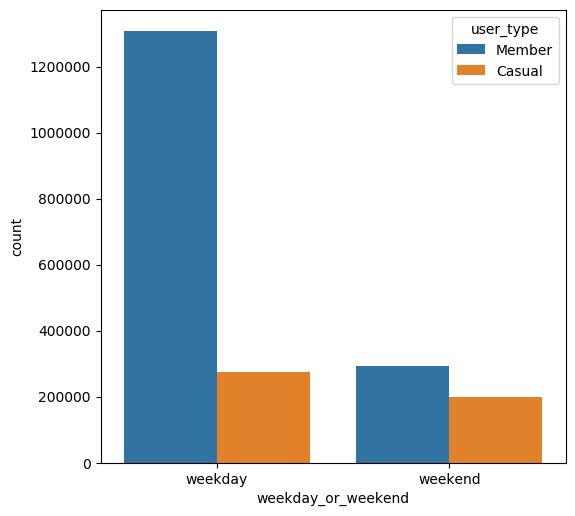

In [33]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.countplot(data=new_df, x="weekday_or_weekend", hue="user_type")
plt.show()

##### Day of Week Usage

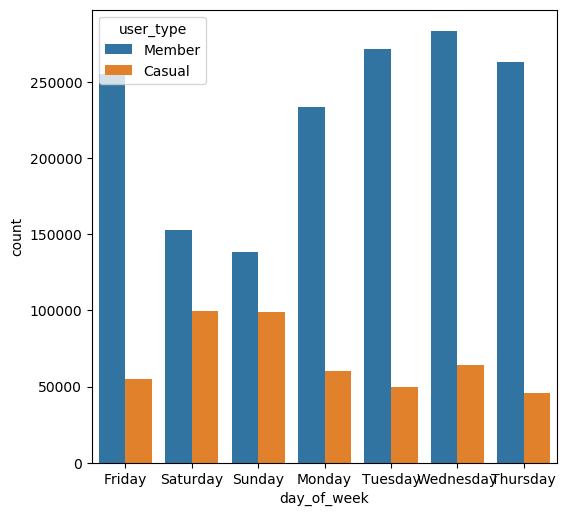

In [34]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.countplot(data=new_df, x="day_of_week", hue="user_type")
plt.show()

##### Hour of Day Usage (24-hour format)

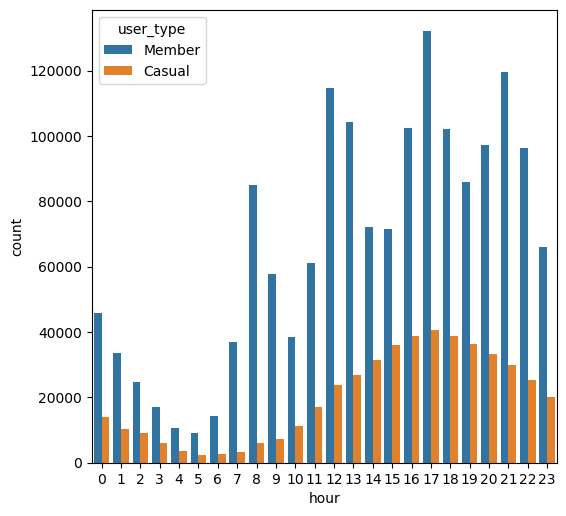

In [35]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.countplot(data=new_df, x="hour", hue="user_type")
plt.show()

<a id="duration-used"></a>

#### Duration Used graphs

##### Season Usage

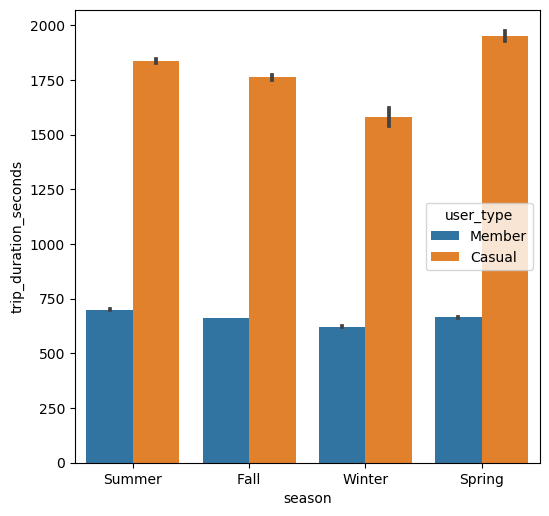

In [36]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.barplot(data=new_df, x="season", y="trip_duration_seconds", hue="user_type")
plt.show()

##### Monthly Usage

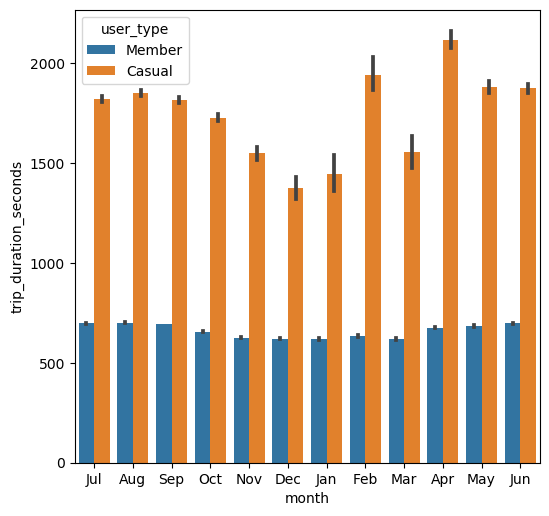

In [37]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.barplot(data=new_df, x="month", y="trip_duration_seconds", hue="user_type")
plt.show()

##### Weekend vs. Weekday Usage

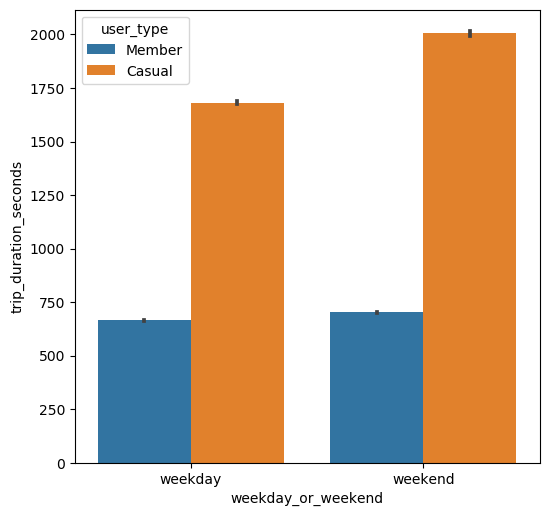

In [38]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.barplot(data=new_df, x="weekday_or_weekend", y="trip_duration_seconds", hue="user_type")
plt.show()

##### Day of Week usage

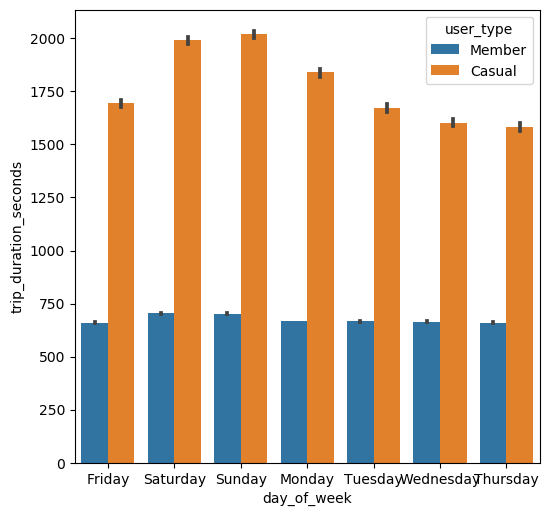

In [39]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.barplot(data=new_df, x="day_of_week", y="trip_duration_seconds", hue="user_type")
plt.show()

##### Hour of Day Usage (24-hour format)

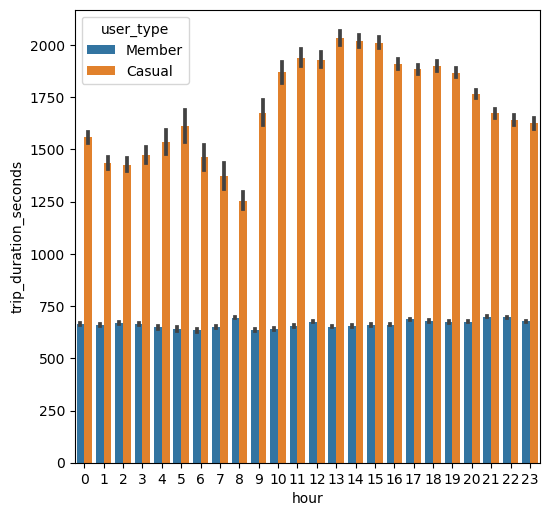

In [40]:
plt.figure(figsize = (6,6), dpi = 100)
plot = sns.barplot(data=new_df, x="hour", y="trip_duration_seconds", hue="user_type")
plt.show()

<a id="station-traffic"></a>

### Station Traffic

In [41]:
station_usage = pd.DataFrame({'to_station_name': df['to_station_name'].value_counts(), 'from_station_name': df['from_station_name'].value_counts()})
station_usage.sort_values(by="to_station_name", ascending=False)

,to_station_name,from_station_name
Union Station,41533,31454
Simcoe St / Wellington St W,32485,30442
York St / Queens Quay W,30085,27772
King St W / Spadina Ave,29198,26676
Queen St W / Portland St,25753,24801
...,...,...
Victoria Park Subway Station - SMART,182,161
Summerhill Ave / MacLennan Ave - SMART,166,196
Dundas St W / Roncesvalles Green P - SMART,135,187
Fringe Next Stage - 7219,125,36


In [42]:
total_usage = station_usage['from_station_name'].sum()
# to_or_from (string) - two possible values, "from_station_name" and "to_station_name"
# top_n_records (int) - the number of top stations to compare to total usage  
def pert_usage(top_n_records, to_or_from):
    return round(station_usage.sort_values(by=to_or_from, ascending=False)[to_or_from].head(top_n_records).sum() / total_usage * 100, 1)

In [43]:
pert_usage(20, "from_station_name")

22.1

<a id="top-20"></a>

#### Top 20 station by usage in the system

Text(0.5, 1.0, 'Source Station')

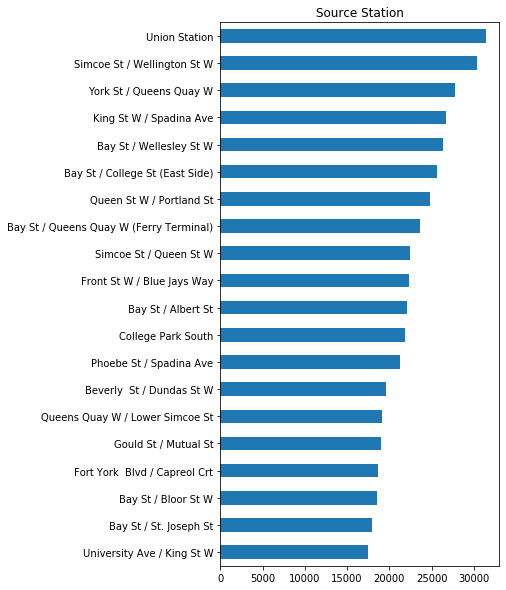

In [44]:
ax1 = df['from_station_name'].value_counts(ascending=False).head(20).plot(kind='barh', figsize=(5,10))
ax1.invert_yaxis()
ax1.set_title("Source Station")

Text(0.5, 1.0, 'Destination Station')

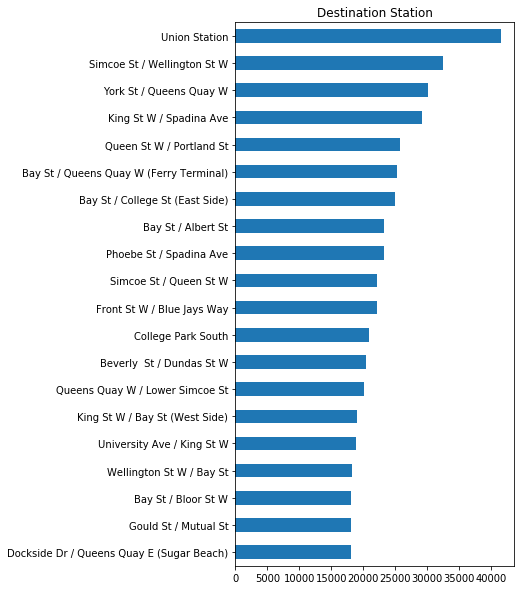

In [45]:
ax2 = df['to_station_name'].value_counts(ascending=False).head(20).plot(kind='barh', figsize=(5,10))
ax2.invert_yaxis()
ax2.set_title("Destination Station")

<a id="common-routes"></a>

#### Route traffic between top 5 stations

In [46]:
# Getting all tha records with the top 5 source and destintation stations in their to and from station names
records = df[(df.from_station_name.isin(df['from_station_name'].value_counts(ascending=False).head(5).index)) & (df.to_station_name.isin(df['to_station_name'].value_counts(ascending=False).head(5).index))]

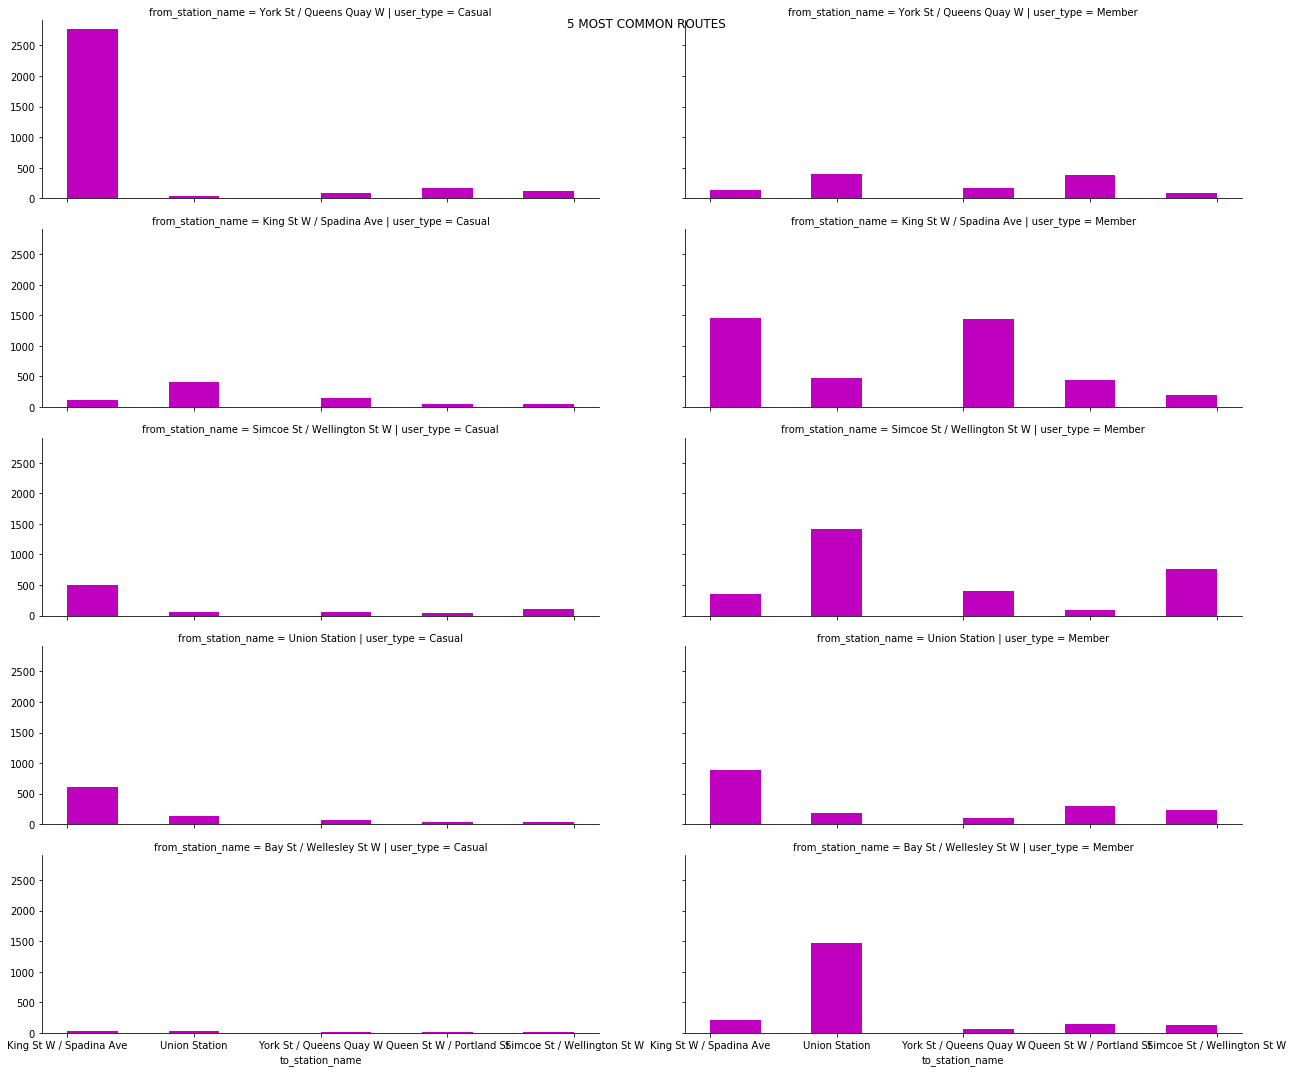

In [47]:
g = sns.FacetGrid(records, col="user_type", row="from_station_name", aspect=3)
g = g.map(plt.hist, "to_station_name", color="m")
g = g.fig.suptitle("5 MOST COMMON ROUTES")

## Conclusion

While analyzing this data, we gained some valuable insights into the bike share project in Toronto. We learned about *who* uses this service, *when* they use it, and *where* they use it the most. A more indepth explaination of our analysis can be found in the report.

Author: Razi Abbasi, Laurianne Garant-Saine, Elina Petrov, Luis Rocholl, and Zoe Xu 